In [2]:
## Basic imports for worling with paths
import os
import sys

## Custom package modules
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import anal_foc_diff_fields as afi
from misloc_mispol_package.optics import diffraction_int as diffi
    
import numpy as np
## For fitting
import scipy.optimize as opt
## For loading matlab files 
import scipy.io as sio
from scipy.constants import physical_constants

## Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)

## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable
## Instructions for adding colorbar to axes 
#     ## Add colorbar
#     divider = make_axes_locatable(axs[ax_idx])
#     cax1 = divider.append_axes("right", size="5%", pad=0.05)
#     fig.colorbar(img1, cax=cax1)

## Useful unit conversion
m_per_nm = fit.m_per_nm

In [3]:
import scipy.constants as con
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
nm = 1e-7
## DEFINE BACKGROUND FOR FITS
eps_b = 1.778

d_minus_a_nm = 10

Lets start with the sphere data Curly sent me

In [4]:
path_to_data = (
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "from_Biteen_group/high_SNR_nanosphere_experiments/")

Text(0.5, 0, 'eV')

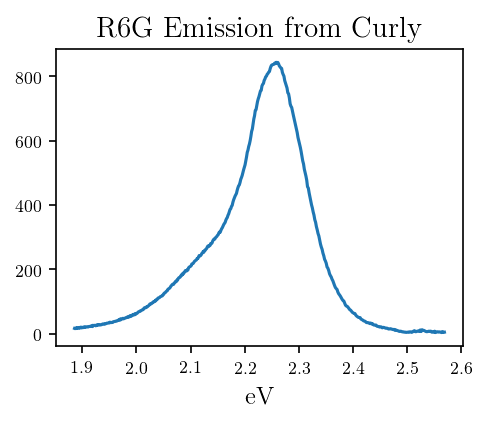

In [5]:
R6G_spectrum = sio.loadmat(os.path.join(path_to_data, "R6G_spectrum.mat"))
# R6G_spectrum.keys()

R6G_spectrum = R6G_spectrum["bdpr6g"]
# R6G_spectrum.shape

# R6G_spectrum[1,:5]
plt.figure(dpi=150)
plt.plot(1240/R6G_spectrum[0], R6G_spectrum[1])
plt.title('R6G Emission from Curly')
plt.xlabel('eV')

Fit 

In [6]:
## Assume isotropic background of water
eps_b = 1.778

In [7]:
def mol_spec_model(
    hw, 
#     eps_b,
#     mass, 
    hw_res, 
    hbargamma_nr,  
    ):
    
#     gamma = hbargamma_nr/hbar

    alpha = cp.sparse_polarizability_tensor(
        cp.fluorophore_mass(70000, hbargamma_nr/hbar), 
        w_res=hw_res/hbar, 
        w=hw/hbar, 
        gamma_nr=hbargamma_nr/hbar, 
        a=0, 
        eps_inf=0, 
        eps_b=eps_b,
        )
#     print(alpha.shape)
    
    sigma = cp.sigma_prefactor(hw/hbar, eps_b) * (
        np.abs(alpha[...,0,0])**2.
        )
    return sigma

In [8]:
mol_hbarws = 1240/R6G_spectrum[0]


In [9]:
#+++++++++++++++++++++++++++++++++++++++++++++

def mol_cost_func(params, *args):
    x=args[0]
    y=args[1]

#     eps_inf=params[0]
#     hw_res=params[0]
#     hgamma=params[1]
    amp = params[-1]
    
    params = params[:-1]
    
#     print(params)
    yfit = mol_spec_model(x,*params)
    
    y_normed = y/y.max()
    yfit_normed = yfit/yfit.max()*amp

    return (y_normed-yfit_normed).ravel()

def two_peak_mol_cost_func(params, *args):
    x=args[0]
    y=args[1]

#     eps_inf=params[0]
#     hw_res=params[0]
#     hgamma=params[1]
    amp1 = params[-1]
    amp2 = params[-2]
    
    params = params[:-2]
    
#     print(params)
    yfit1 = mol_spec_model(x,*params[:2])
    yfit2 = mol_spec_model(x,*params[2:])
    
    y_normed = y/y.max()
    yfit_normed = (yfit1/yfit1.max()*amp1) + (yfit2/yfit2.max()*amp2)

    return (y_normed-yfit_normed).ravel()

#+++++++++++++++++++++++++++++++++++++++++++++

### Try fitting 1 oscillator to mol spectrum

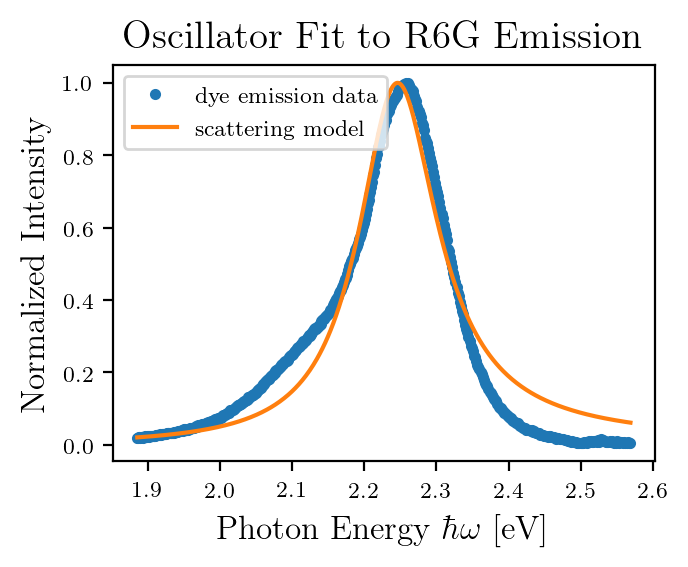

In [10]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([
    2.25, .05,
#     .25, .05, 0.9, 
    0.9])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[mol_hbarws, R6G_spectrum[1],]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    mol_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = mol_spec_model(mol_hbarws, *result['x'][:-1])

norm_mol_fit_result = fit_result/fit_result.max()

# higher_damp = result['x'].copy()
# higher_damp[2] = 0.22
# higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(mol_hbarws, *higher_damp)

data = R6G_spectrum[1]
norm_data = data/data.max()

plt.figure(dpi=200)

plt.plot(mol_hbarws, norm_data, label='dye emission data', ls=' ', marker='.')
# plt.plot(mol_hbarws, ret_fit_scat_1(mol_hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(mol_hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(mol_hbarws, norm_mol_fit_result, label='scattering model', ls='-')
# plt.plot(mol_hbarws, normed_peak1, ls='--', lw=1, label='oscillator 1')
# plt.plot(mol_hbarws, normed_peak2, ls='--', lw=1, label='oscillator 2')

# plt.xlim([np.min(long_mol_hbarws),np.max(trans_mol_hbarws)])
plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Normalized Intensity')
plt.title(r'Oscillator Fit to R6G Emission')
plt.legend()

# plt.figure(dpi=100)
# plt.plot(trans_mol_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_mol_hbarws, ret_fit_scat_2(trans_mol_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_mol_hbarws, ret_fit_scat_2(trans_mol_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_mol_hbarws), np.max(trans_mol_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

In [11]:
result['x']

array([2.24412138, 0.1341578 , 1.00626086])

### Try fitting two oscillators to the mol spectrum

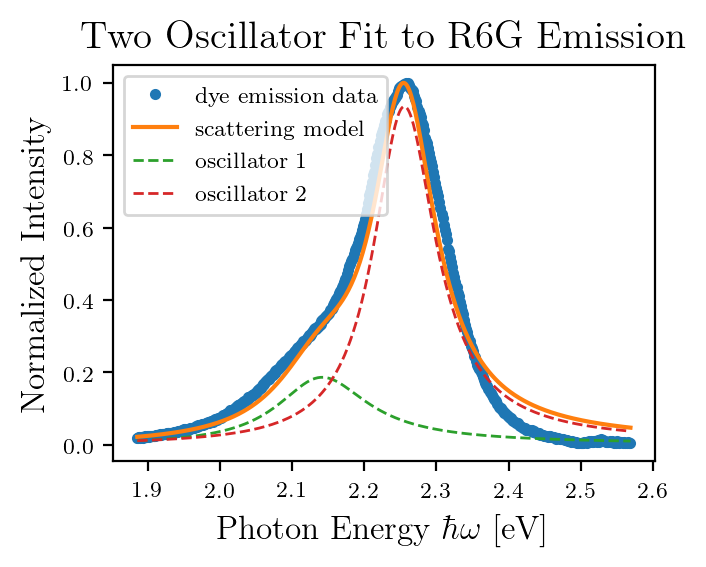

In [12]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([2.25, .05, .25, .05, 0.9, 0.9])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[mol_hbarws, R6G_spectrum[1],]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    two_peak_mol_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
# fit_result = mol_spec_model(mol_hbarws, *result['x'][:-1])
fit_result = (
    mol_spec_model(mol_hbarws, *result['x'][:2]) * result['x'][-1]
    +
    mol_spec_model(mol_hbarws, *result['x'][2:-2]) * result['x'][-2]
)

norm_fit_result = fit_result/fit_result.max()

peak1 = mol_spec_model(mol_hbarws, *result['x'][:2]) * result['x'][-1]

normed_peak1 = peak1/fit_result.max()

peak2 = mol_spec_model(mol_hbarws, *result['x'][2:-2]) * result['x'][-2]

normed_peak2 = peak2/fit_result.max()


# higher_damp = result['x'].copy()
# higher_damp[2] = 0.22
# higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(mol_hbarws, *higher_damp)

data = R6G_spectrum[1]
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(mol_hbarws, norm_data, label='dye emission data', ls=' ', marker='.')
# plt.plot(mol_hbarws, ret_fit_scat_1(mol_hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(mol_hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(mol_hbarws, norm_fit_result,label='scattering model', ls='-')
plt.plot(mol_hbarws, normed_peak1, ls='--', lw=1, label='oscillator 1')
plt.plot(mol_hbarws, normed_peak2, ls='--', lw=1, label='oscillator 2')

# plt.xlim([np.min(long_mol_hbarws),np.max(trans_mol_hbarws)])
plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Normalized Intensity')
plt.title(r'Two Oscillator Fit to R6G Emission')
plt.legend()

# plt.figure(dpi=100)
# plt.plot(trans_mol_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_mol_hbarws, ret_fit_scat_2(trans_mol_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_mol_hbarws, ret_fit_scat_2(trans_mol_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_mol_hbarws), np.max(trans_mol_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

In [13]:
result['x']

array([2.13904734, 0.1535714 , 2.25425592, 0.10481735, 0.97681753,
       0.21590805])

#### Fit plasmon spectra

Text(0.5, 0, '$\\lambda$ [nm]')

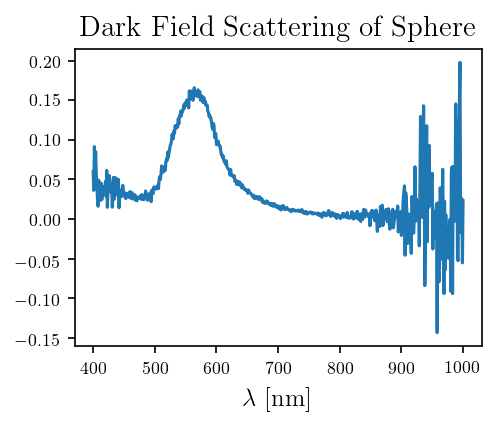

In [14]:
AuNP_DFSpec = sio.loadmat(os.path.join(path_to_data, "AuNP_DFSpec.mat"))
AuNP_DFSpec.keys()

AuNP_DFSpec = np.hstack((AuNP_DFSpec['wl'], AuNP_DFSpec['DF'][:, None,0])).T

plt.figure(dpi=150)
plt.plot(AuNP_DFSpec[0], AuNP_DFSpec[1])
plt.title("Dark Field Scattering of Sphere")
plt.xlabel(r'$\lambda$ [nm]')

##### Cropping off noisy bs

Text(0.5, 0, '$\\lambda$ [nm]')

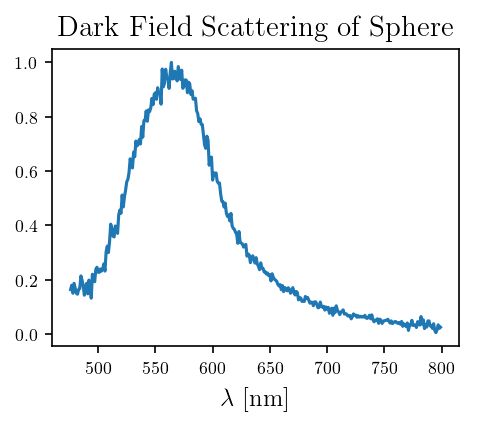

In [15]:
AuNP_DFSpec=AuNP_DFSpec[:, np.argwhere(np.logical_and(AuNP_DFSpec[0]>475, AuNP_DFSpec[0]<800))]

plt.figure(dpi=150)
plt.plot(
    AuNP_DFSpec[0], 
    AuNP_DFSpec[1]/np.max(AuNP_DFSpec[1])
    )
plt.title("Dark Field Scattering of Sphere")
plt.xlabel(r'$\lambda$ [nm]')

Fit

In [16]:
hbarws = 1240/AuNP_DFSpec[0]

## ----

def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, a):
    return cp.sigma_scat_ret_sphere(
        hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, eps_b, a*nm)
# def ret_fit_scat_2(hbarw, eps_inf, hbarw_p, hbargamma, a_1, a_2):
#     return cp.short_sigma_scat_ret_pro_ellip(hbarw/hbar, eps_inf, hbarw_p/hbar, hbargamma/hbar, eps_b, a_1*nm, a_2*nm)*1e10

In [17]:
#+++++++++++++++++++++++++++++++++++++++++++++

def cost_func(params, *args):
    x=args[0]
    y=args[1]

#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a = params[3]
    amp = params[-1]
    params = params[:-1]
    
    yfit=ret_fit_scat_1(x,*params)
    
    y_normed = y/y.max()
    yfit_normed = yfit/yfit.max() * amp

    return (y_normed-yfit_normed).ravel()

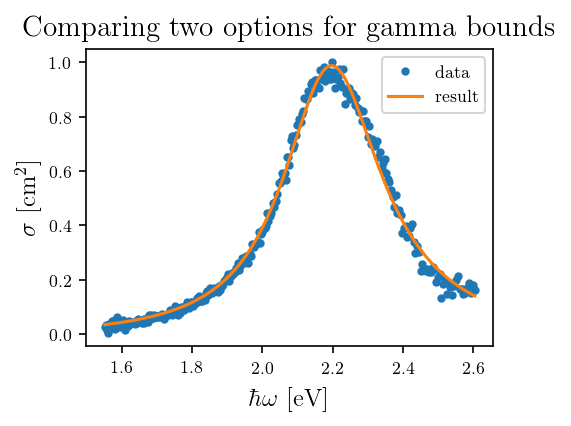

In [18]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([11.6817827 ,  9.56022562,  0.09554153, 40.24119972, 0.95])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[hbarws, AuNP_DFSpec[1],]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(0, np.inf),
    bounds=(
        [5, 5, 0.09, 30, .9],
        [20, 20, 0.1, 50, 1.1]
        )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hbarws, *result['x'][:-1])
norm_fit_result = fit_result/fit_result.max() * result['x'][-1]

higher_damp = result['x'].copy()
higher_damp[2] = 0.22
higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)

data = AuNP_DFSpec[1]
norm_data = data/data.max()

plt.figure(dpi=150)
plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.')
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(hbarws, norm_fit_result,label='result', ls='-')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Comparing two options for gamma bounds')
plt.legend()

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

In [19]:
np.array([[1,0,0],[0,0,0],[0,0,0]])[...,0,0]

array(1)

In [20]:
## hbar*gamma resticted to min = 0.09
result['x']

array([ 9.0500746 ,  9.00109957,  0.09      , 43.62519421,  0.98790271])

In [21]:
## hbar*gamma resticted to min = 0.01
result['x']

array([ 9.0500746 ,  9.00109957,  0.09      , 43.62519421,  0.98790271])

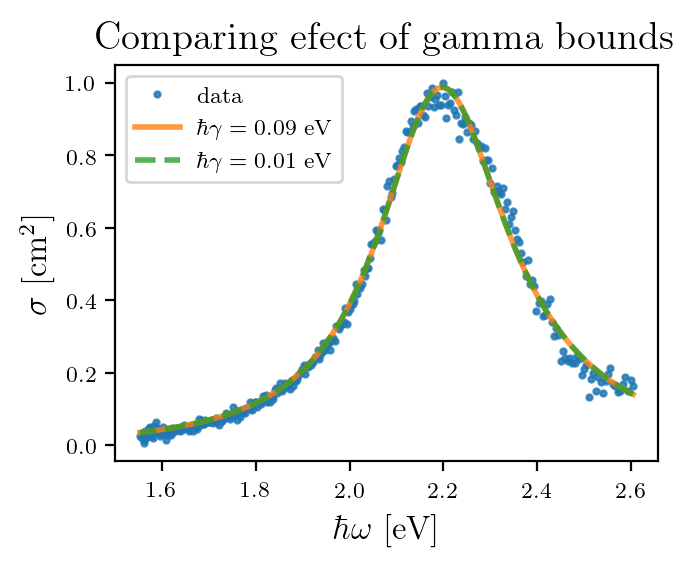

In [22]:
result_pt01 = np.array([ 9.0500746 ,  9.00109957,  0.09      , 43.62519421,  0.98790271])
result_pt09 = np.array([1.03773703e+01, 9.58675792e+00, 1.00000000e-02, 4.62298489e+01,
       9.87512454e-01])

#+++++++++++++++++++++++++++++++++++++++++++++
fit_result_pt01 = ret_fit_scat_1(hbarws, *result_pt01[:-1])
norm_fit_result_pt01 = fit_result/fit_result.max() * result_pt01[-1]

fit_result_pt09 = ret_fit_scat_1(hbarws, *result_pt09[:-1])
norm_fit_result_pt09 = fit_result/fit_result.max() * result_pt09[-1]

data = AuNP_DFSpec[1]
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(hbarws, norm_data, label='data', ls='', marker='o', markersize = 2, alpha=0.8)
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(hbarws, norm_fit_result_pt09 ,label=r'$\hbar\gamma=0.09$ eV', lw=2, alpha=.8, ls='-')
plt.plot(hbarws, norm_fit_result_pt01 ,label=r'$\hbar\gamma=0.01$ eV', lw=2, alpha=.8, ls='--')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Comparing efect of gamma bounds')
plt.legend()

I guess I should also fit the same simulated sphere

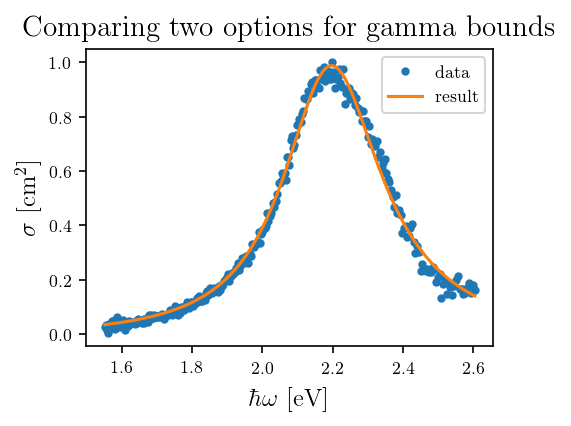

In [23]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([11.6817827 ,  9.56022562,  0.09554153, 40.24119972, 0.95])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

args=[hbarws, AuNP_DFSpec[1],]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(0, np.inf),
    bounds=(
        [5, 5, 0.09, 30, .9],
        [20, 20, 0.1, 50, 1.1]
        )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hbarws, *result['x'][:-1])
norm_fit_result = fit_result/fit_result.max() * result['x'][-1]

higher_damp = result['x'].copy()
higher_damp[2] = 0.22
higher_damp[3] = 44

# high_damp_result = ret_fit_scat_1(hbarws, *higher_damp)

data = AuNP_DFSpec[1]
norm_data = data/data.max()

plt.figure(dpi=150)
plt.plot(hbarws, norm_data, label='data', ls=' ', marker='.')
# plt.plot(hbarws, ret_fit_scat_1(hbarws, *ini_guess_both),label='initial', ls='--')
# plt.plot(hbarws, 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(hbarws, norm_fit_result,label='result', ls='-')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Comparing two options for gamma bounds')
plt.legend()

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

In [24]:
path_to_sim = (
    "/Users/chair/Documents/MATLAB/sphere_dip_spectrum/")
sca_spec = sio.loadmat(os.path.join(path_to_sim, "sph_scat_spec.mat"))
sca_spec.keys()

dict_keys(['__header__', '__version__', '__globals__', 'enei', 'sca'])

In [25]:
sca_spec['sca'].T[0].shape

(500,)

In [26]:
sca_spec['enei'].shape

(1, 500)

In [27]:
args=[1240/sca_spec['enei'][0], sca_spec['sca'].T[0],]

args[1] = args[1][np.argwhere(args[0]<2.5)]

In [28]:
for arg in args:
    print(arg.shape)

(500,)
(380, 1)


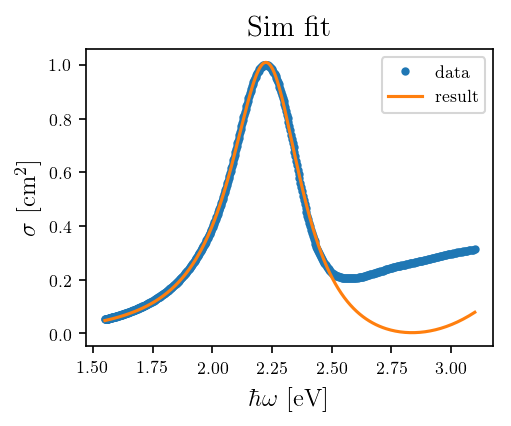

In [29]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([11.6817827 ,  9.56022562,  0.09554153, 40.24119972, 0.95])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

eneis = 1240/sca_spec['enei'][0, :]
spec = sca_spec['sca'].T[0, :]

high_enei_cutoff = 2.4

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(0, np.inf),
    bounds=(
        [5, 5, 0.09, 30, .9],
        [20, 20, 0.1, 50, 1.1]
        )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(eneis, *result['x'][:-1])
norm_fit_result = fit_result/fit_result.max() * result['x'][-1]

# high_damp_result = ret_fit_scat_1(args[0], *higher_damp)

data = spec
norm_data = data/data.max()

plt.figure(dpi=150)
plt.plot(eneis, norm_data, label='data', ls=' ', marker='.')
# plt.plot(args[0], ret_fit_scat_1(args[0], *ini_guess_both),label='initial', ls='--')
# plt.plot(args[0], 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
plt.plot(eneis, norm_fit_result,label='result', ls='-')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Sim fit')
plt.legend()

# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

In [30]:
result['x']

array([20.        , 12.10973031,  0.1       , 46.72711329,  1.00878266])

In [31]:
sim_fit_plas_result = result

## load the coupled dipole decay rates from BEM's Mie calculator

In [32]:
path_to_sim = (
    "/Users/chair/Documents/MATLAB/sphere_dip_spectrum/")

mie_rates = sio.loadmat(os.path.join(path_to_sim, "sphere_dip_drive_mie_spec.mat"))
mie_rates.keys()

dict_keys(['__header__', '__version__', '__globals__', 'enei', 'rad0', 'tot0'])

Text(0, 0.5, 'Rate enhancement')

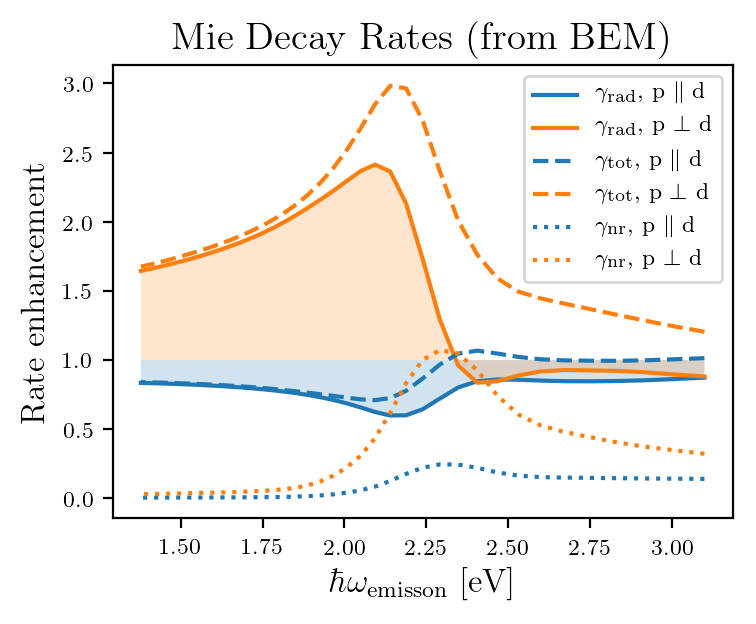

In [33]:
# mie_wavelengths, mie_radiative_rate, mie_decay_rate = mie_rates['enei', 'rad0', 'tot0']
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4,3))


ax.plot(1240/mie_rates['enei'][0], mie_rates['rad0'].T[0], label=r'$\gamma_\mathrm{rad}$, p $\parallel$ d')
ax.fill_between(1240/mie_rates['enei'][0], 1, mie_rates['rad0'].T[0], ALPHA=.2)
ax.plot(1240/mie_rates['enei'][0], mie_rates['rad0'].T[1], label=r'$\gamma_\mathrm{rad}$, p $\perp$ d')
ax.fill_between(1240/mie_rates['enei'][0], 1, mie_rates['rad0'].T[1], ALPHA=.2)

ax.plot(1240/mie_rates['enei'][0], mie_rates['tot0'].T[0], ls='--', c='C0', label=r'$\gamma_\mathrm{tot}$, p $\parallel$ d')
ax.plot(1240/mie_rates['enei'][0], mie_rates['tot0'].T[1], ls='--', c='C1', label=r'$\gamma_\mathrm{tot}$, p $\perp$ d')

ax.plot(
    1240/mie_rates['enei'][0], 
    (mie_rates['tot0'].T[0]-mie_rates['rad0'].T[0]), 
    ls='dotted', 
    c='C0', 
    label=r'$\gamma_\mathrm{nr}$, p $\parallel$ d')
ax.plot(
    1240/mie_rates['enei'][0], 
    (mie_rates['tot0'].T[1]-mie_rates['rad0'].T[1]), 
    ls='dotted', 
    c='C1', 
    label=r'$\gamma_\mathrm{nr}$, p $\perp$ d')


ax.legend()
ax.set_title('Mie Decay Rates (from BEM)')
ax.set_xlabel('$\hbar\omega_{\mathrm{emisson}}$ [eV]')
ax.set_ylabel('Rate enhancement')


I think I can use these as my enhancement factors: $g_r(\omega)$ and $g_{ET}(\omega)$, next up is to integral normalized the fluorescence spectrum

In [34]:
import scipy.integrate as integrate

Text(0.5, 1.0, 'Integral normalized emission spectrum')

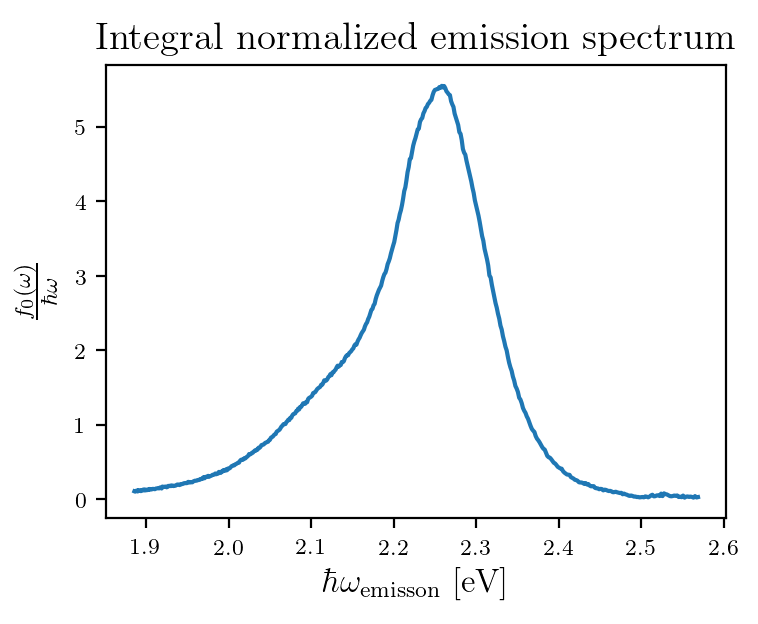

In [35]:
mol_em_norm = integrate.simps(R6G_spectrum[1], 1240/R6G_spectrum[0,])
plt.figure(dpi=200, figsize=(4,3))
plt.plot(1240/R6G_spectrum[0], R6G_spectrum[1]/mol_em_norm)
plt.ylabel(r'$\frac{f_0(\omega)}{\hbar\omega}$')
plt.xlabel('$\hbar\omega_{\mathrm{emisson}}$ [eV]')
plt.title('Integral normalized emission spectrum')

In [36]:
q_yield = 0.9

In [37]:
## Calculate the total rates from the Ringler paper
from scipy import interpolate 
# f = interpolate.interp1d(x, y)


gr_of_hbaromega_par = interpolate.interp1d(
    1240/mie_rates['enei'][0], mie_rates['rad0'].T[0])

gET_of_hbaromega_par = interpolate.interp1d(
    1240/mie_rates['enei'][0], 
    (mie_rates['tot0'].T[0]-mie_rates['rad0'].T[0]),)

gr_of_hbaromega_perp = interpolate.interp1d(
    1240/mie_rates['enei'][0], mie_rates['rad0'].T[1])

gET_of_hbaromega_perp = interpolate.interp1d(
    1240/mie_rates['enei'][0], 
    (mie_rates['tot0'].T[1]-mie_rates['rad0'].T[1]),)

f0_of_hbaromega = interpolate.interp1d(
    1240/R6G_spectrum[0], R6G_spectrum[1]/mol_em_norm)

In [38]:
gamma_r_on_gamma_r0_para, gamma_r_on_gamma_r0_para_error = integrate.quad(
    lambda hbarw: gr_of_hbaromega_par(hbarw) * f0_of_hbaromega(hbarw), 
    np.min(1240/R6G_spectrum[0]), 
    np.max(1240/R6G_spectrum[0])
    )

gamma_ET_on_gamma_r0_para, gamma_ET_on_gamma_r0_para_error = integrate.quad(
    lambda hbarw: gET_of_hbaromega_par(hbarw) * f0_of_hbaromega(hbarw), 
    np.min(1240/R6G_spectrum[0]), 
    np.max(1240/R6G_spectrum[0])
    )

gamma_r_on_gamma_r0_perp, gamma_r_on_gamma_r0_perp_error = integrate.quad(
    lambda hbarw: gr_of_hbaromega_perp(hbarw) * f0_of_hbaromega(hbarw), 
    np.min(1240/R6G_spectrum[0]), 
    np.max(1240/R6G_spectrum[0])
    )

gamma_ET_on_gamma_r0_perp, gamma_ET_on_gamma_r0_perp_error = integrate.quad(
    lambda hbarw: gET_of_hbaromega_perp(hbarw) * f0_of_hbaromega(hbarw), 
    np.min(1240/R6G_spectrum[0]), 
    np.max(1240/R6G_spectrum[0])
    )



/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.
/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from spl

In [39]:
def g_em(
    hbarw,
    nu_0,
    gr_of_hbaromega,
    gamma_r_on_gamma_r0,
    gamma_ET_on_gamma_r0,
    ):
    """ Takes vector of energies and the internal quantum yield of the 
        dye: nu_0.
        """
    g = gr_of_hbaromega(hbarw) / (
        nu_0 * (
            gamma_r_on_gamma_r0
            +
            gamma_ET_on_gamma_r0
            +
            (1/nu_0 - 1)) 
        )
    return g

In [40]:
## Load excitation spectrum from Thermo Fisher website to select excitation frequency
thermo_fisher_dye_data = np.loadtxt('BODIPY R6G.csv', skiprows=1, delimiter=',')

In [41]:
max_excitation_wavelength = thermo_fisher_dye_data.T[0][np.argmax(thermo_fisher_dye_data.T[1])]
max_excitation_wavelength

528.0

#### Matlab simulation run to calculate excitation enhancement for simulated spectrum

Load field enhancements aroung a nanosphere at the excitation wavelength of 528. Incident field is polarized in x, so coordinates along x coorespond to $\mathbf{p} \parallel \mathbf{d}$ and coordinates along the y axis coorespond to $\mathbf{p} \perp \mathbf{d}$

In [42]:
excitation_fields = sio.loadmat(os.path.join(path_to_sim, "sphere_planewave_fields.mat"))
excitation_fields.keys()

dict_keys(['__header__', '__version__', '__globals__', 'e_field', 'field_points'])

In [43]:
arg_field_50nm_para = np.argwhere(excitation_fields['field_points'][:,0] == 40+d_minus_a_nm)
arg_field_50nm_perp = np.argwhere(excitation_fields['field_points'][:,1] == 40+d_minus_a_nm)

In [44]:
sim_field_at_50nm_from_surface_para = excitation_fields['e_field'][arg_field_50nm_para.ravel()]
sim_field_at_50nm_from_surface_para

array([[-0.33881658+2.67774360e+00j, -0.00106172+1.31950286e-03j,
         0.18365335-2.18886034e-01j]])

In [45]:
np.mean([1,2,3])

2.0

In [46]:
sim_field_at_50nm_from_surface_perp = excitation_fields['e_field'][arg_field_50nm_perp.ravel()]
sim_field_at_50nm_from_surface_perp

array([[-3.03567671e-01-8.79061256e-01j,  1.08920657e-03+2.59031023e-03j,
        -2.60330185e-04-5.49518571e-04j]])

The Ringler paper says that the excitation enhancement is 
\begin{equation}
g_{exc}(\omega) = \left|\frac{
    \mathbf{p}\cdot (\mathbf{E}_0 + \mathbf{E}_{ind})
    }{
    \mathbf{p}\cdot \mathbf{E}_0
    }\right|^2
\end{equation}

Not exactly what to think of the diole moment sitting there, but I think I will just take the unit vector. If $\mathbf{E}_0 = \hat{\epsilon}E_0$, 
\begin{equation}
g_{exc}(\omega_exc) = \left|
    1 + \frac{\hat{\mathbf{p}} \cdot \mathbf{E}_{ind}}{\hat{\mathbf{p}} \cdot\mathbf{E}_0}
    \right|^2
\end{equation}

#### for both para and per $g_{exc}$, we take the $x$ component of the field because the molecule dipole should be parallel to the excitation field. Is this true? Seems like it should readdy be an orientational average. I thnk that is what Stephan is doing. 

In [47]:
g_exc_para = np.mean(1 + np.abs(sim_field_at_50nm_from_surface_para)**2.)
g_exc_para

3.455583328053594

In [48]:
g_exc_perp = np.mean(1 + np.abs(sim_field_at_50nm_from_surface_perp)**2.)
g_exc_perp

1.2883034293584492

Text(0.5, 1.0, 'Simulating Plasmon-Enhanced Fluorescence')

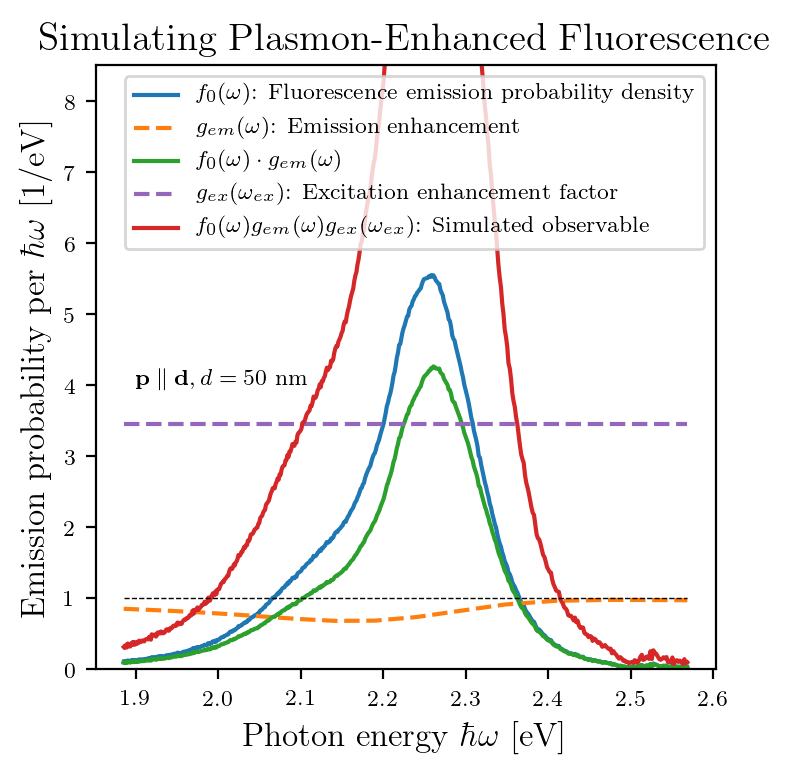

In [49]:
g_em_para = g_em(
    1240/R6G_spectrum[0], 
    q_yield,
    gr_of_hbaromega_par,
    gamma_r_on_gamma_r0_para, 
    gamma_ET_on_gamma_r0_para,
    )

plt.figure(figsize=(4,4), dpi=200)
plt.plot(
    1240/R6G_spectrum[0], 
    R6G_spectrum[1]/mol_em_norm,
    c='C0',
    label='$f_0(\omega)$: Fluorescence emission probability density'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    g_em_para,
    ls='--',    
    c='C1',
    label=r'$g_{em}(\omega)$: Emission enhancement'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    g_em_para* R6G_spectrum[1]/mol_em_norm, 
    c='C2',
    label=r'$f_0(\omega) \cdot g_{em}(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    (
        g_exc_para * np.ones(R6G_spectrum[0].shape)
    ), 
    ls='--',
    c='C4',
    label=r'$g_{ex}(\omega_{ex})$: Excitation enhancement factor'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    (
        g_em_para
        * 
        R6G_spectrum[1]/mol_em_norm 
        * 
        g_exc_para
    ),
    c='C3',
    label=r'$f_0(\omega)  g_{em}(\omega) g_{ex}(\omega_{ex})$: Simulated observable'
    )

plt.plot(
    [np.min(1240/R6G_spectrum[0]), np.max(1240/R6G_spectrum[0])], 
    [1,1], 
    c='k',ls='--', lw=0.5,
#     label=r'$f_0(\omega)  g_{em}(\omega) g_{ex}(\omega_{ex})$'
    )
plt.ylim([0,8.5])
plt.ylabel('Emission probability per $\hbar\omega$ [1/eV]')
plt.xlabel('Photon energy $\hbar\omega$ [eV]')
plt.text(1.9, 4, '$\mathbf{p} \parallel \mathbf{d}, d = 50$ nm')
plt.legend()
plt.title('Simulating Plasmon-Enhanced Fluorescence')

In [50]:
gamma_ET_on_gamma_r0_para

0.1917152643519352

Text(0.5, 1.0, 'Simulating Plasmon-Enhanced Fluorescence')

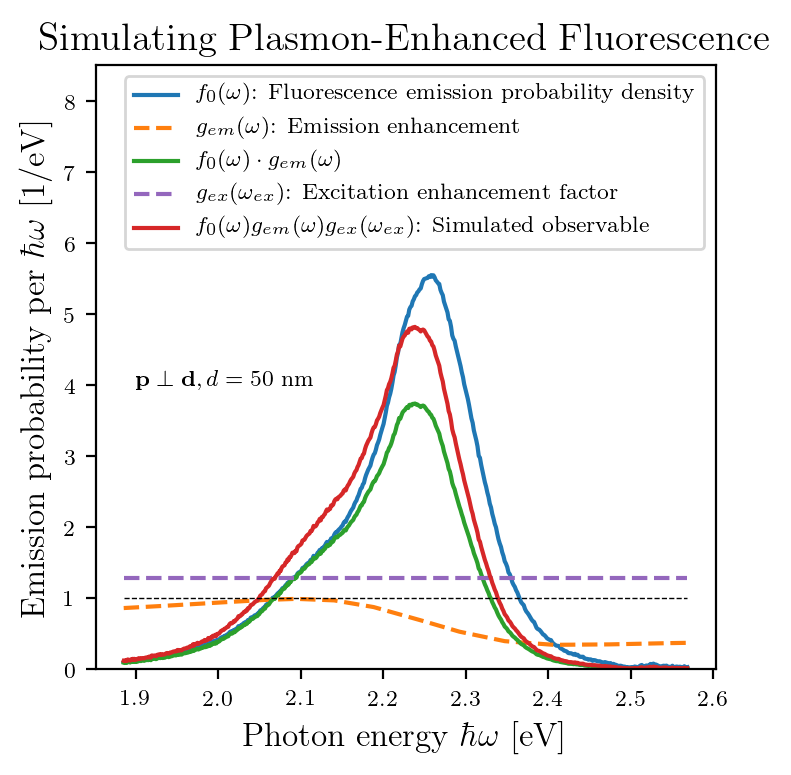

In [51]:
g_em_perp = g_em(
    1240/R6G_spectrum[0], 
    q_yield,
#     .5,
    gr_of_hbaromega_perp,
    gamma_r_on_gamma_r0_perp, 
    gamma_ET_on_gamma_r0_perp,
    )

plt.figure(figsize=(4,4), dpi=200)
plt.plot(
    1240/R6G_spectrum[0], 
    R6G_spectrum[1]/mol_em_norm,
    c='C0',
    label='$f_0(\omega)$: Fluorescence emission probability density'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    g_em_perp,
    ls='--',    
    c='C1',
    label=r'$g_{em}(\omega)$: Emission enhancement'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    g_em_perp* R6G_spectrum[1]/mol_em_norm, 
    c='C2',
    label=r'$f_0(\omega) \cdot g_{em}(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    (
        g_exc_perp * np.ones(R6G_spectrum[0].shape)
    ), 
    ls='--',
    c='C4',
    label=r'$g_{ex}(\omega_{ex})$: Excitation enhancement factor'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    (
        g_em_perp
        * 
        R6G_spectrum[1]/mol_em_norm 
        * 
        g_exc_perp
    ),
    c='C3',
    label=r'$f_0(\omega)  g_{em}(\omega) g_{ex}(\omega_{ex})$: Simulated observable'
    )

plt.plot(
    [np.min(1240/R6G_spectrum[0]), np.max(1240/R6G_spectrum[0])], 
    [1,1], 
    c='k',ls='--', lw=0.5,
#     label=r'$f_0(\omega)  g_{em}(\omega) g_{ex}(\omega_{ex})$'
    )
plt.ylim([0,8.5])
plt.ylabel('Emission probability per $\hbar\omega$ [1/eV]')
plt.xlabel('Photon energy $\hbar\omega$ [eV]')
plt.text(1.9, 4, '$\mathbf{p} \perp \mathbf{d}, d = 50$ nm')
plt.legend()
plt.title('Simulating Plasmon-Enhanced Fluorescence')

Text(0.5, 1.0, '$g_{em}$ scaling for $d-a = 10$ nm')

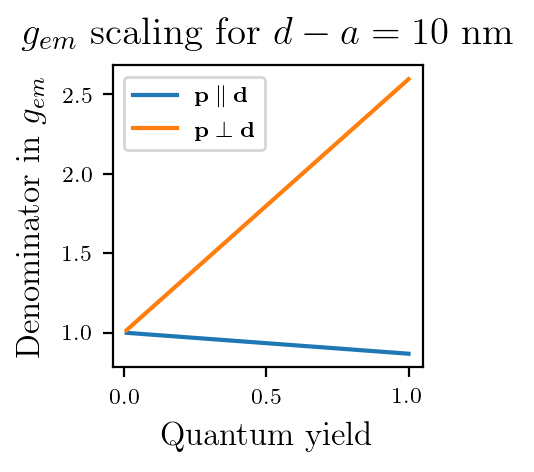

In [52]:
def para_denom(nu_0): 
    denom = nu_0 * (
            gamma_r_on_gamma_r0_para
            +
            gamma_ET_on_gamma_r0_para
            +
            (1/nu_0 - 1)) 
    return denom

def perp_denom(nu_0): 
    denom = nu_0 * (
            gamma_r_on_gamma_r0_perp
            +
            gamma_ET_on_gamma_r0_perp
            +
            (1/nu_0 - 1)) 
    return denom

nu = np.linspace(0.01,1)

plt.figure(dpi=200, figsize=(2,2))
plt.plot(nu, para_denom(nu), label='$\mathbf{p} \parallel \mathbf{d}$')
plt.plot(nu, perp_denom(nu), label='$\mathbf{p} \perp \mathbf{d}$')
plt.legend()
plt.xlabel('Quantum yield')
plt.ylabel('Denominator in $g_{em}$')
plt.title('$g_{em}$ scaling for $d-a = 10$ nm')

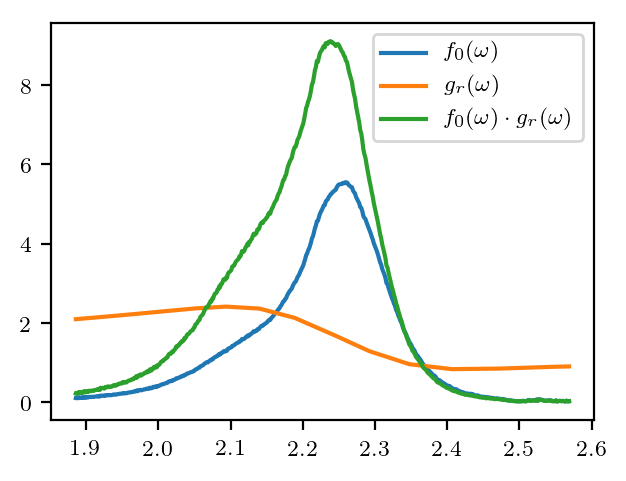

In [53]:
plt.plot(
    1240/R6G_spectrum[0], 
    R6G_spectrum[1]/mol_em_norm,
    label='$f_0(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    gr_of_hbaromega_perp(1240/R6G_spectrum[0]), label=r'$g_r(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    gr_of_hbaromega_perp(1240/R6G_spectrum[0]) * f0_of_hbaromega(1240/R6G_spectrum[0]),
    label='$f_0(\omega) \cdot g_r(\omega)$'
    )
plt.legend()

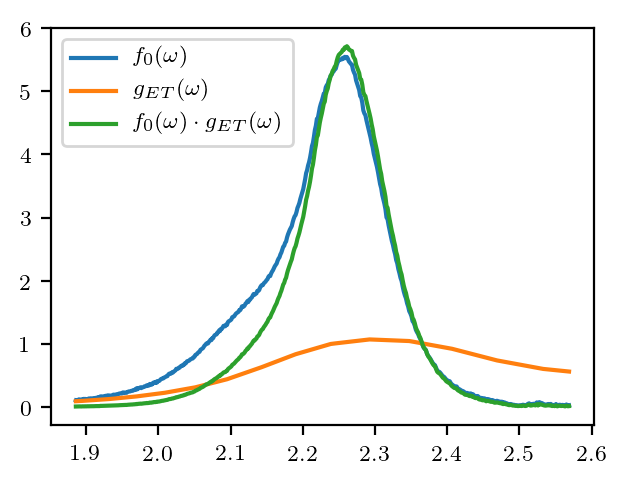

In [54]:
plt.plot(
    1240/R6G_spectrum[0], 
    R6G_spectrum[1]/mol_em_norm,
    label='$f_0(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    gET_of_hbaromega_perp(1240/R6G_spectrum[0]), label=r'$g_{ET}(\omega)$'
    )
plt.plot(
    1240/R6G_spectrum[0], 
    gET_of_hbaromega_perp(1240/R6G_spectrum[0]) * f0_of_hbaromega(1240/R6G_spectrum[0]),
    label='$f_0(\omega) \cdot g_{ET}(\omega)$'
    )
plt.legend()

### Almost Ready to model the coupeld spectrum
I just need to figure out how to work the emission enhancement into the coupled oscillator model. BU ti guess I could just do the easy thing (and maybe the safe thing) and do the same thing I did to simulation, but with the model. 

#### Compute plasmon field at mol location with model
Should be able to do something like 
\begin{equation}
\mathbf{E}(\mathbf{x}_{mol}, \omega_{exc}) = \mathbf{G} * \mathbf{p}_{plas}(\omega_{exc})
\end{equation}

In [55]:
def model_exc_enh(d, hbarw, alpha, E_inc_hat):
    """ Returns: E(mol_location)/|E_inc|
        Args:
            d: (N, 3) seperation vectors
            hbarw: single excitation energy in eV
            alpha: (3,3) polarizability tensor
            E_inc_hat: (3,) or (1,3) unit vector indicating polarization of 
                incident field
            
        """
    _G = cp.G(hbarw, d)
    p_on_E = np.einsum('...ij,...j->...i', alpha, E_inc_hat)
    E_enh = np.einsum('...ij,...j->...i', _G, p_on_E)
    
    return E_enh

In [56]:
model_exc_enh(d=np.array([[1,0,0]]), hbarw=1, alpha=np.array([[1,0,0], [0,0,0], [0,0,0]]), E_inc_hat=np.array([[1,0,0]])).shape

(1, 3)

In [57]:
exc_hbarw = 1240/max_excitation_wavelength


# sim_plas_fit_param= [20., 12.10973031,  0.1       , 46.72711329,  1.00878266]
sim_plas_fit_param=[13.99604932, 10.05123876,  0.28443696, 36.1993746 ] ## From amplitude-aware fit
#       eps_inf, hbarw_p/hbar, hbargamma/hbar, eps_b, a*nm)
model_alpha = cp.sparse_ret_sphere_polarizability_Drude(
    w=exc_hbarw/hbar, 
    eps_inf=sim_plas_fit_param[0], 
    w_p=sim_plas_fit_param[1]/hbar, 
    gamma=sim_plas_fit_param[2]/hbar, 
    eps_b=eps_b, 
    a=sim_plas_fit_param[3]*nm
    )

In [58]:
model_alpha.shape

(3, 3)

In [59]:
exc_hbarw

2.3484848484848486

In [60]:
model_field_enh_factor = model_exc_enh(
    np.array([[40+10, 0, 0]])*nm, 
    exc_hbarw, 
    model_alpha, 
    np.array([1,0,0])
    )

In [61]:
1 + np.abs(model_field_enh_factor[0,0])**2,

(5.69627789580637,)

This looks alot better because of the amplitude aware fit parameters, even though they don't loko too physical. 

This is very different from the simulated result on ~1.1... but I'll try pulling the model together anyway for now

In [63]:
mol_fit_params = [2.24412138, 0.1341578]

def alpha_mol_of_w(w): 
    alpha = cp.sparse_polarizability_tensor(
        cp.fluorophore_mass(70000, mol_fit_params[1]), 
        w_res=mol_fit_params[0]/hbar, 
        w=w, 
        gamma_nr=mol_fit_params[1]/hbar, 
        a=0, 
        eps_inf=0, 
        eps_b=eps_b,
        )
    return alpha

def alpha_pla_of_w(w): 
    alpha = cp.sparse_ret_sphere_polarizability_Drude(
        w=w, 
        eps_inf=sim_plas_fit_param[0], 
        w_p=sim_plas_fit_param[1]/hbar, 
        gamma=sim_plas_fit_param[2]/hbar, 
        eps_b=eps_b, 
        a=sim_plas_fit_param[3]*nm
        )
    return alpha

test_d = (40+d_minus_a_nm)*nm
test_d_col = np.array([[test_d, 0, 0]])


def dipoles_of_omega(w):
    """Returns [p_0, p_1] both of shape ~ (# omegas, 3)"""
    return cp.dipole_moments_per_omega(
        mol_angle=0,
        plas_angle=0,
        d=test_d_col,
        drive_hbar_w=w*hbar,
        alpha0_diag_of_omega=alpha_mol_of_w,
        alpha1_diag_of_omega=alpha_pla_of_w,)

def perp_dipoles_of_omega(w):
    """Returns [p_0, p_1] both of shape ~ (# omegas, 3)"""
    return cp.dipole_moments_per_omega(
        mol_angle=np.pi/2,
        plas_angle=0,
        d=test_d_col,
        drive_hbar_w=w*hbar,
        alpha0_diag_of_omega=alpha_mol_of_w,
        alpha1_diag_of_omega=alpha_pla_of_w,)


In [64]:
hbar_ws = np.linspace(2.,2.7, 500)

test_spec, terms = cp.sigma_scat_coupled(
    dipoles_of_omega,
    test_d_col,
    hbar_ws,
    )

perp_model_spec, perp_terms = cp.sigma_scat_coupled(
    perp_dipoles_of_omega,
    test_d_col,
    hbar_ws,
    )

(2, 2.5)

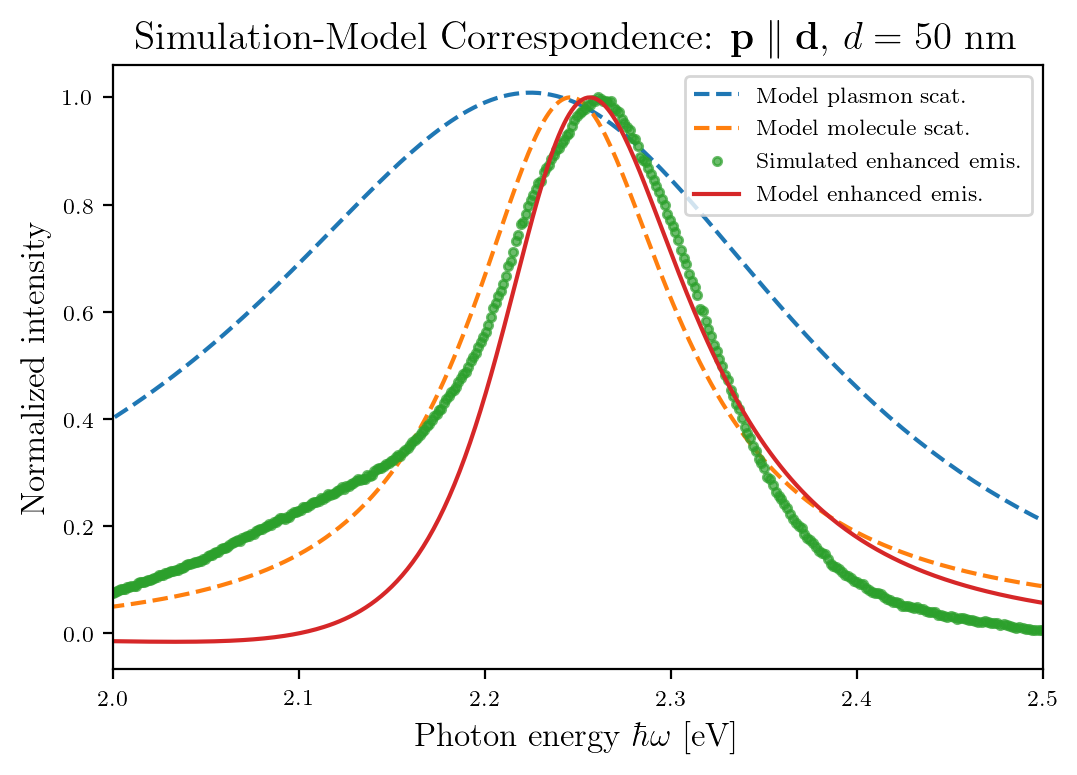

In [88]:
plt.figure(dpi=200, figsize=(6,4))
plt.plot(eneis, norm_fit_result,label='Model plasmon scat.', ls='--')
plt.plot(mol_hbarws, norm_mol_fit_result, label='Model molecule scat.', ls='--')

# plt.plot(
#     1240/R6G_spectrum[0], 
#     R6G_spectrum[1]/R6G_spectrum[1].max(),
#     label='$f_0(\omega)$',
#     ls='',
#     marker='.',
#     markersize=.5,
#     alpha=.4,
#     c='C1'
#     )

simulated_fluo_enhancement = (
    g_em_para
    * 
    R6G_spectrum[1]/mol_em_norm 
    * 
    g_exc_para
    )
plt.plot(
    1240/R6G_spectrum[0], 
    simulated_fluo_enhancement/simulated_fluo_enhancement.max(), 
    ls='',
    marker='.',
    alpha=.7,
    label=r'Simulated enhanced emis.'
    )
plt.plot(hbar_ws, test_spec/test_spec.max(), label='Model enhanced emis.')
# plt.plot(hbar_ws, terms[0]/test_spec.max(), label='interf')
# plt.plot(hbar_ws, terms[1]/test_spec.max(), label='mol term')
# plt.plot(hbar_ws, terms[2]/test_spec.max(), label='plas term')

plt.legend()
plt.ylabel('Normalized intensity')
plt.xlabel('Photon energy $\hbar\omega$ [eV]')
# plt.text( 2.025, .9, '')
plt.title('Simulation-Model Correspondence: $\mathbf{p} \parallel \mathbf{d},\,d = 50$ nm')
plt.xlim([2,2.5])

(2, 2.5)

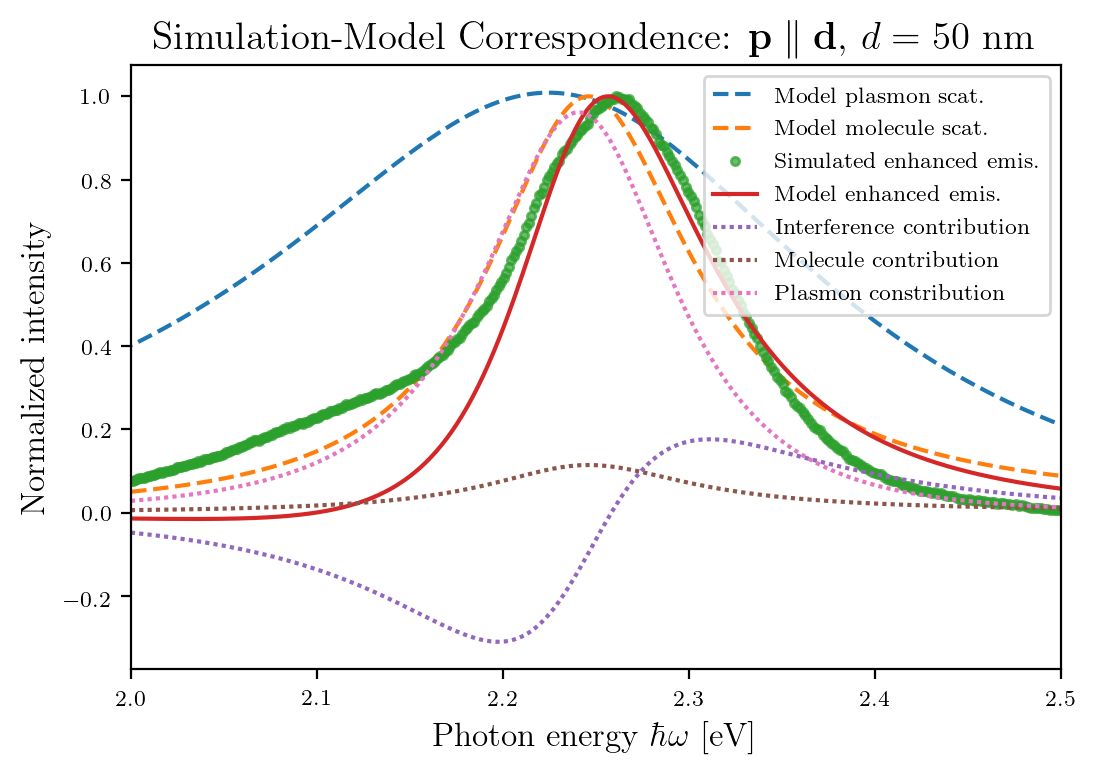

In [76]:
plt.figure(dpi=200, figsize=(6,4))
plt.plot(eneis, norm_fit_result,label='Model plasmon scat.', ls='--')
plt.plot(mol_hbarws, norm_mol_fit_result, label='Model molecule scat.', ls='--')

simulated_fluo_enhancement = (
    g_em_para
    * 
    R6G_spectrum[1]/mol_em_norm 
    * 
    g_exc_para
    )
plt.plot(
    1240/R6G_spectrum[0], 
    simulated_fluo_enhancement/simulated_fluo_enhancement.max(), 
    ls='',
    marker='.',
    alpha=.7,
    label=r'Simulated enhanced emis.'
    )
plt.plot(hbar_ws, test_spec/test_spec.max(), label='Model enhanced emis.')
plt.plot(hbar_ws, terms[0]/test_spec.max(), ls=(0,(1,1)), label='Interference contribution')
plt.plot(hbar_ws, terms[1]/test_spec.max(), ls=(0,(1,1)), label='Molecule contribution')
plt.plot(hbar_ws, terms[2]/test_spec.max(), ls=(0,(1,1)), label='Plasmon constribution')

plt.legend()
plt.ylabel('Normalized intensity')
plt.xlabel('Photon energy $\hbar\omega$ [eV]')
# plt.text( 2.025, .9, '')
plt.title('Simulation-Model Correspondence: $\mathbf{p} \parallel \mathbf{d},\,d = 50$ nm')
plt.xlim([2,2.5])

(2, 2.5)

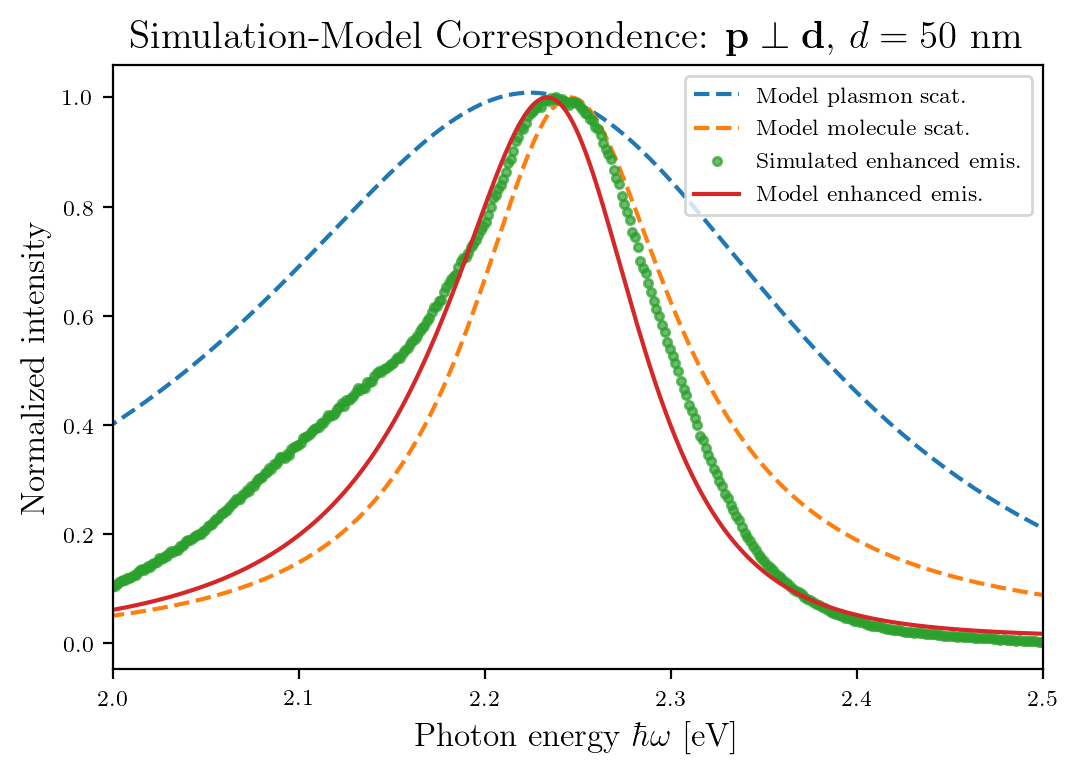

In [79]:
plt.figure(dpi=200, figsize=(6,4))
plt.plot(eneis, norm_fit_result,label='Model plasmon scat.', ls='--')
plt.plot(mol_hbarws, norm_mol_fit_result, label='Model molecule scat.', ls='--')

simulated_fluo_enhancement = (
    g_em_perp
    * 
    R6G_spectrum[1]/mol_em_norm 
    * 
    g_exc_perp
    )
plt.plot(
    1240/R6G_spectrum[0], 
    simulated_fluo_enhancement/simulated_fluo_enhancement.max(), 
    ls='',
    marker='.',
    alpha=.7,
    label=r'Simulated enhanced emis.'
    )
plt.plot(hbar_ws, perp_model_spec/perp_model_spec.max(), label='Model enhanced emis.')
# plt.plot(hbar_ws, model_terms[0]/perp_model_spec.max(), label='interf')
# plt.plot(hbar_ws, model_terms[1]/perp_model_spec.max(), label='mol term')
# plt.plot(hbar_ws, model_terms[2]/perp_model_spec.max(), label='plas term')

plt.legend()
plt.ylabel('Normalized intensity')
plt.xlabel('Photon energy $\hbar\omega$ [eV]')
# plt.text( 2.025, .9, '')
plt.title('Simulation-Model Correspondence: $\mathbf{p} \perp \mathbf{d},\,d = 50$ nm')
plt.xlim([2,2.5])

(2, 2.5)

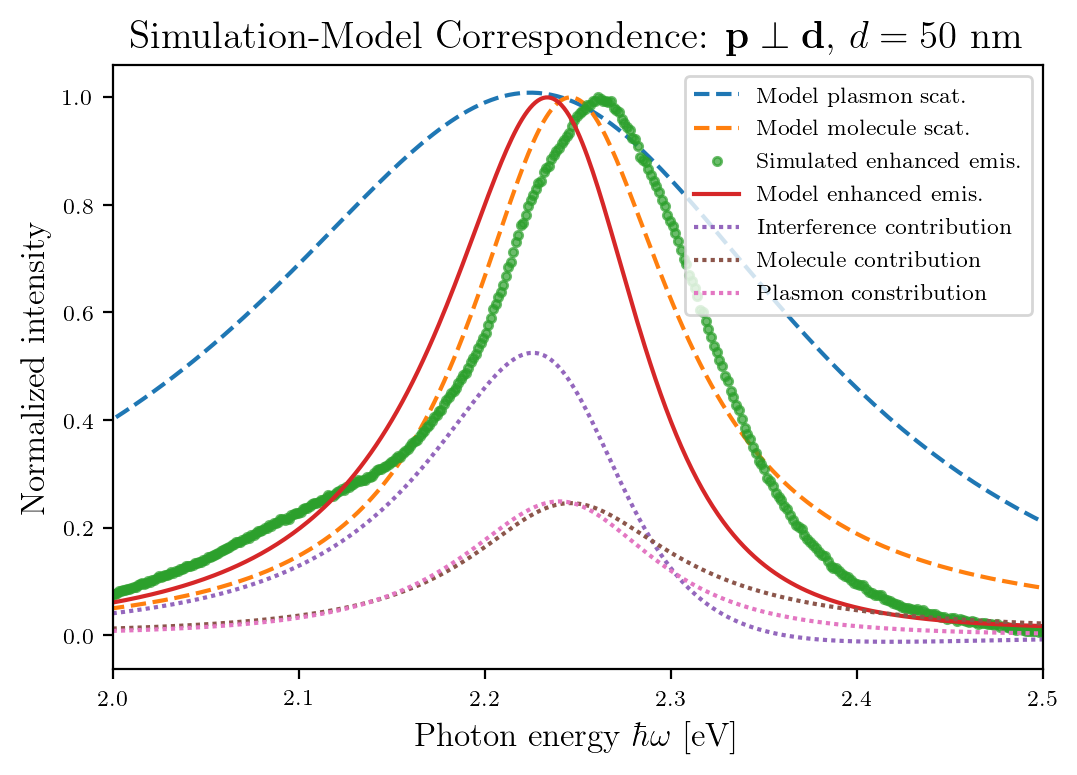

In [89]:
plt.figure(dpi=200, figsize=(6,4))
plt.plot(eneis, norm_fit_result,label='Model plasmon scat.', ls='--')
plt.plot(mol_hbarws, norm_mol_fit_result, label='Model molecule scat.', ls='--')

# simulated_fluo_enhancement = (
#     g_em_para
#     * 
#     R6G_spectrum[1]/mol_em_norm 
#     * 
#     g_exc_para
#     )
plt.plot(
    1240/R6G_spectrum[0], 
    simulated_fluo_enhancement/simulated_fluo_enhancement.max(), 
    ls='',
    marker='.',
    alpha=.7,
    label=r'Simulated enhanced emis.'
    )
plt.plot(hbar_ws, perp_model_spec/perp_model_spec.max(), label='Model enhanced emis.')
plt.plot(hbar_ws, perp_terms[0]/perp_model_spec.max(), ls=(0,(1,1)), label='Interference contribution')
plt.plot(hbar_ws, perp_terms[1]/perp_model_spec.max(), ls=(0,(1,1)), label='Molecule contribution')
plt.plot(hbar_ws, perp_terms[2]/perp_model_spec.max(), ls=(0,(1,1)), label='Plasmon constribution')

plt.legend()
plt.ylabel('Normalized intensity')
plt.xlabel('Photon energy $\hbar\omega$ [eV]')
# plt.text( 2.025, .9, '')
plt.title('Simulation-Model Correspondence: $\mathbf{p} \perp \mathbf{d},\,d = 50$ nm')
plt.xlim([2,2.5])

Looking at this makes me realize that the single oscillator model of the molecule is never going to work. Most of the deviation in the fluorescence spectrum with coupling is going to look like a change in relative amplitude of the two peaks. That is what Stephan showed in his paper. 

This is especially going to be an issue since fitting the total amplitudes is hard. Or is it? I guess it is not in simulation as I should have exact crossections. 

questions if I am to model the molecule emission as two oscillators
- in the higher energy dipole oriented in the same direction? I don't see why it has to be. 

I am realizing there is more wrong here then just the model of the mol. The simulated psectra shifts blue from the isolated mol, but the model shifts red. Maybe part of the issue is I don't have the plasmon parameterized correctly because I was not fitting the amplitude. Let me go back and check that.

In [ ]:
for sep in np.linspace(10, 150, 10):
    mol_fit_params = [2.24412138, 0.1341578]

    def alpha_mol_of_w(w): 
        alpha = cp.sparse_polarizability_tensor(
            cp.fluorophore_mass(70000, mol_fit_params[1]), 
            w_res=mol_fit_params[0]/hbar, 
            w=w, 
            gamma_nr=mol_fit_params[1]/hbar, 
            a=0, 
            eps_inf=0, 
            eps_b=eps_b,
            )
        return alpha

    def alpha_pla_of_w(w): 
        alpha = cp.sparse_ret_sphere_polarizability_Drude(
            w=w, 
            eps_inf=sim_plas_fit_param[0], 
            w_p=sim_plas_fit_param[1]/hbar, 
            gamma=sim_plas_fit_param[2]/hbar, 
            eps_b=eps_b, 
            a=sim_plas_fit_param[3]*nm
            )
        return alpha

    test_d = (sep)*nm
    test_d_col = np.array([[test_d, 0, 0]])


    def dipoles_of_omega(w):
        """Returns [p_0, p_1] both of shape ~ (# omegas, 3)"""
        return cp.dipole_moments_per_omega(
            mol_angle=0,
            plas_angle=0,
            d=test_d_col,
            drive_hbar_w=w*hbar,
            alpha0_diag_of_omega=alpha_mol_of_w,
            alpha1_diag_of_omega=alpha_pla_of_w,)


    hbar_ws = np.linspace(2.,2.7, 500)

    test_spec, terms = cp.sigma_scat_coupled(
        dipoles_of_omega,
        test_d_col,
        hbar_ws,
        )

    plt.figure(dpi=200)
    plt.plot(eneis, norm_fit_result,label='plas. fit', ls='--')
    plt.plot(mol_hbarws, norm_mol_fit_result, label='mol. fit', ls='--')

    plt.plot(hbar_ws, test_spec/test_spec.max(), label='modeled enh.')

    simulated_fluo_enhancement = (
        g_em_para
        * 
        R6G_spectrum[1]/mol_em_norm 
        * 
        g_exc_para
        )
    plt.plot(
        1240/R6G_spectrum[0], 
        simulated_fluo_enhancement/simulated_fluo_enhancement.max(), 
        label=r'simulated enh.'
        )
    plt.plot(hbar_ws, terms[0]/test_spec.max(), label='interf')
    plt.plot(hbar_ws, terms[1]/test_spec.max(), label='mol term')
    plt.plot(hbar_ws, terms[2]/test_spec.max(), label='plas term')

    plt.legend()
    plt.xlim([2,2.5])

#### Try refitting plasmon with amplitude

In [ ]:
nm # cm per nm

In [ ]:
#+++++++++++++++++++++++++++++++++++++++++++++

def no_amp_cost_func(params, *args):
    x=args[0]
    y=args[1]

#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a = params[3]
#     amp = params[-1]
#     params = params[:-1]
    
    yfit=ret_fit_scat_1(x,*params)
    
    y = y*(nm**2)*1e10 ## to cm^2 from nm^2 (data from BEM)
    yfit = yfit*1e10 ## in cm^2

    return (y-yfit).ravel()

In [ ]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([
    11.6817827, 
    9.56022562, 
    0.09554153, 
    40.24119972, 
#     0.95
    ])
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

eneis = 1240/sca_spec['enei'][0, :]
spec = sca_spec['sca'].T[0, :]

high_enei_cutoff = 2.4

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    no_amp_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
#     bounds=(
#         [  0, 0,  0.09, 0],
#         [ np.inf, np.inf, 0.099, np.inf]
#     )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(eneis, *result['x'])
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = ret_fit_scat_1(args[0], *higher_damp)

data = spec*(nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='data', ls=' ', marker='.')
plt.plot(eneis, fit_result,label='result', ls='-')

# plt.plot(eneis, norm_data, label='data', ls=' ', marker='.')
# plt.plot(args[0], ret_fit_scat_1(args[0], *ini_guess_both),label='initial', ls='--')
# plt.plot(args[0], 0.9*high_damp_result/high_damp_result.max(),label='test', ls='-')
# plt.plot(eneis, norm_fit_result,label='result', ls='-')

# plt.xlim([np.min(long_hbarws),np.max(trans_hbarws)])
plt.xlabel(r'$\hbar\omega$ [eV]')
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Sim fit')
plt.legend()

result['x']
# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend()

In [ ]:
amp_plas_fit_param= result['x']
#       eps_inf, hbarw_p/hbar, hbargamma/hbar, eps_b, a*nm)
model_alpha = cp.sparse_ret_sphere_polarizability_Drude(
    w=exc_hbarw/hbar, 
    eps_inf=amp_plas_fit_param[0], 
    w_p=amp_plas_fit_param[1]/hbar, 
    gamma=amp_plas_fit_param[2]/hbar, 
    eps_b=eps_b, 
    a=amp_plas_fit_param[3]*nm
    )

What if I try subtracting off the higher energy stuff?

In [ ]:
#+++++++++++++++++++++++++++++++++++++++++++++

def hiengau_cost_func(params, *args):
    x=args[0]
    y=args[1]
    
    ## Parameteres;
    ##     eps_inf=params[0]
    ##     w_p=params[1]
    ##     gamma=params[2]
    ##     a = params[3]
    ##
    ## Gaussian parameters
    gau_amp = params[4]
    mu = params[5]
    std_dev = params[6]
    
    high_en_gau = gau_amp*np.exp(-(x-mu)**2./std_dev**2.)*1E-10
    
    yfit = (
        ret_fit_scat_1(x,*params[:4]) 
        + 
        high_en_gau
        )
    
    y = y*(nm**2)*1e10 ## to cm^2 from nm^2 (data from BEM)
    yfit = yfit*1e10 ## in cm^2

    return (y-yfit).ravel()

In [ ]:
#+++++++++++++++++++++++++++++++++++++++++++++

ini_guess_both=np.array([
    11.6817827, 
    9.56022562, 
    0.09554153, 
    40.24119972, 
    .5,
    4,
    2,
#     0.95
    ])

ini = ret_fit_scat_1(eneis, *ini_guess_both[:4])
ini_gaus = (
    ini_guess_both[4]
    *
    np.exp(
        -(ini_guess_both[5]-eneis)**2.
        /
        ini_guess_both[6]**2.
        )*1E-10
    )

data = spec*(nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='data', ls=' ', marker='.')
plt.plot(eneis, ini,label='result', ls='-')
plt.plot(eneis, ini_gaus,label='gauss', ls='-')
plt.legend()

In [ ]:
# ini_guess_both=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_both   #parameter guess

eneis = 1240/sca_spec['enei'][0, :]
spec = sca_spec['sca'].T[0, :]

high_enei_cutoff = 3

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    hiengau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
    bounds=(
        [  0, 0,  0.09, 30, .1, 3.3, .5,],
        
        [ np.inf, np.inf, np.inf, np.inf,  np.inf,  4,  2.1,]
    )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(eneis, *result['x'][:4])
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = ret_fit_scat_1(args[0], *higher_damp)

data = spec*(nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='simulated scattering', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result,label='model dipole scattering', ls='-')


fit_gauss = (
    result['x'][4]
    *
    np.exp(
        -(result['x'][5]-eneis)**2.
        /
        result['x'][6]**2.
        )*1E-10
    )
plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'Parameterization of 80 nm Gold Sphere')
plt.legend()

result['x']
# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend() 

In [ ]:
ini_guess_both=np.array([
    11.6817827, 
    9.56022562, 
    0.0900554153, 
    40.24119972, 
    .5,
    4,
    2,
#     0.95
    ])
params0=ini_guess_both   #parameter guess

eneis = 1240/sca_spec['enei'][0, :]
spec = sca_spec['sca'].T[0, :]

high_enei_cutoff = 3

args=[
    eneis[eneis<high_enei_cutoff],
    spec[eneis<high_enei_cutoff]
    ]

# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

result=opt.least_squares(
    hiengau_cost_func, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(0, np.inf),
#     bounds=(
#         [5, 5, 0.01, 39,],
#         [50, 20, 0.09, 41,]
#         )
    bounds=(
        [  0, 0,  0.09, 40, .1, 3.3, .5,],
        
        [ np.inf, np.inf, 0.0901, np.inf,  np.inf,  4,  2.1,]
    )
#     x_scale=[10,1,1E-2,10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(eneis, *result['x'][:4])
norm_fit_result = fit_result/fit_result.max()

# high_damp_result = ret_fit_scat_1(args[0], *higher_damp)

data = spec*(nm**2)
norm_data = data/data.max()

plt.figure(dpi=200)
plt.plot(eneis, data, label='simulated scattering', ls=' ', marker='.',
#          markersize=2,
         alpha=.8
        )
plt.plot(eneis, fit_result,label='model dipole scattering', ls='-')


fit_gauss = (
    result['x'][4]
    *
    np.exp(
        -(result['x'][5]-eneis)**2.
        /
        result['x'][6]**2.
        )*1E-10
    )
plt.plot(eneis, fit_gauss,label='phenomenological gaussian', ls='-')


plt.xlabel(r'Photon Energy $\hbar\omega$ [eV]')
plt.ylabel(r'Cross Section $\sigma_\mathrm{scat}$ [cm$^2$]')
plt.title(r'Parameterization of 80 nm Gold Sphere')
plt.legend()

result['x']
# plt.figure(dpi=100)
# plt.plot(trans_hbarws, trans_sigma, label='data', ls=' ', marker='.')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *ini_guess_both), label='initial', ls='--')
# plt.plot(trans_hbarws, ret_fit_scat_2(trans_hbarws, *result['x'])*1e-10, label='result', ls='-')
# plt.xlim([np.min(long_hbarws), np.max(trans_hbarws)])
# plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.ylabel(r'$\sigma$ [cm$^2$]')
# plt.title(r'Transverse Mode Fit')
# plt.legend() 

Other things to chec; 
- is my expression for the coupled scattering crossection correct? I would have thought that flipping the sign on the interference term would push the coupled spectrum to the right, but it didnt. 

Also it seems like the interference term in the scattering crossection seems to be zero

In [ ]:
a = 40*nm
e = 4.80320425*1E-10
m = e**2./(a**3. * (2.2/hbar)**2.) * (1 + (17.77869783-1.788)/3)

In [ ]:
m

In [ ]:
1/(1 + (1.788*e**2./(m*a*c**2.)))